In [1]:
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
import albumentations as A
from torchvision.models import resnet18, ResNet18_Weights
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import os
import cv2
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
class MyDataset(Dataset):
    def __init__(self,
                 images_folder,
                 transform=None,
                 *args, **kwargs):

        super().__init__(*args, **kwargs)

        self.images_folder = images_folder

        self.transform = transform if transform else \
            A.Compose(
                [
                    ToTensorV2(),
                ]
            )
        self.model_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

        self.images_paths = []
        self._read_images_names()

    def _read_images_names(self):
        for root, dirs, files in os.walk(self.images_folder):
            for image_name in files:
                img_path = os.path.join(root, image_name)

                _, ext = os.path.splitext(img_path)
                if ext not in ['.png', '.jpg', '.jpeg']:
                    continue

                self.images_paths.append(img_path)

    def __len__(self):
        return len(self.images_paths)
    
    def get_original_image(self, idx):
        filepath = self.images_paths[idx]
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        return image

    def __getitem__(self, idx):
        filepath = self.images_paths[idx]
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = self.transform(image=image)["image"]
        image = self.model_transform(image)

        return image.float()

In [3]:
# my_dataset = MyDataset(images_folder="/Users/alex-usatoff/Downloads/faces_datasets/ds1")
my_dataset = MyDataset(images_folder=r"C:\Users\Lenovo\Downloads\archive (1)\UTKFace")

In [4]:
len(my_dataset)

23708

In [5]:
class EmbeddingsExtractor(pl.LightningModule):

    def __init__(self):
        super(EmbeddingsExtractor, self).__init__()

        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        self.model.fc = torch.nn.Sequential(
            torch.nn.Flatten(),
        )

        for name, param in self.model.named_parameters():
            # if "fc" in name or "layer4" in name or "layer3" in name:
            #     continue
            param.requires_grad = False

        # self.device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.model.to(self.device)

    def forward(self, x):
        return self.model(x)

    def get_embedings(self, dataset):
        dataloader = DataLoader(dataset, batch_size=16)
        self.eval()
        embeds = []
        with torch.no_grad():
            for batch in dataloader:
                batch = batch.to(self.device)
                outputs = self(batch)
                embeds.append(outputs)
        return torch.cat(embeds)

In [6]:
my_dataset_1, my_dataset_2 = torch.utils.data.Subset(
    my_dataset, 
    range(
        len(my_dataset) // 2)
    ), \
    torch.utils.data.Subset(
        my_dataset, 
        range(len(my_dataset) // 2, 
        len(my_dataset))
    )

In [7]:
import torch.utils
import torch.utils.data


def get_embeds_example(dataset, extractor, subsample_size=1_000, random_seed=42):
    np.random.seed(random_seed)
    subsample_size = min(subsample_size, len(dataset))
    idxs = np.random.choice(range(len(dataset)), subsample_size, replace=False)
    subset = torch.utils.data.Subset(dataset, idxs)
    
    embeds = extractor.get_embedings(subset)
    return embeds

In [8]:
extractor = EmbeddingsExtractor()

In [9]:
len(my_dataset)

23708

In [10]:
get_embeds_example(my_dataset, extractor, 10).shape

C:\Users\Lenovo\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([10, 512])

In [11]:
embeds1, embeds2 = get_embeds_example(my_dataset_1, extractor, random_seed=42), get_embeds_example(my_dataset_2, extractor, random_seed=69)

In [12]:
from scipy.spatial.distance import cosine
from sklearn.metrics import mean_squared_error as mse
from itertools import product

def _mean_similarity(emb1, emb2):

    sim_sum = 0
    for el1 in emb1:
        for el2 in emb2:
            sim_sum += np.dot(el1, el2) / (np.linalg.norm(el1) * np.linalg.norm(el2))
    
    return sim_sum / len(emb1) / len(emb2)


def embeds_list_similarity(emb1, emb2):
    emb1, emb2 = np.array(emb1), np.array(emb2)

    return _mean_similarity(emb1, emb2)

In [13]:
embeds_list_similarity(embeds1, embeds2)

0.7846727028174698

In [14]:
def get_similarities(ds1, ds2, subsample_size=100, iters=100):
    similarities_list = []
    for seed in tqdm(range(iters)):
        embeds1, embeds2 = get_embeds_example(
            ds1, extractor, random_seed=seed, subsample_size=subsample_size), get_embeds_example(
                ds2, extractor, random_seed=seed**2, subsample_size=subsample_size)
        similarities_list.append(embeds_list_similarity(embeds1, embeds2))
    return similarities_list

In [15]:
similarities_list = get_similarities(my_dataset_1, my_dataset_2)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

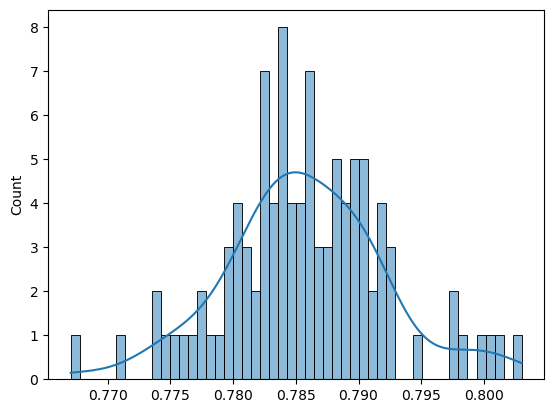

In [16]:
sns.histplot(similarities_list, bins=50, kde=True)

In [17]:
# test_dataset = MyDataset(images_folder="/Users/Lenovo/Downloads/faces_datasets/ds2")
test_dataset = MyDataset(images_folder=r"C:\Users\Lenovo\Downloads\faces_datasets\ds2_raw\00_test_img_input\test\images")
len(test_dataset), len(my_dataset)

(6000, 23708)

In [18]:
similarities_test_list_1 = get_similarities(my_dataset_1, test_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Lenovo\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

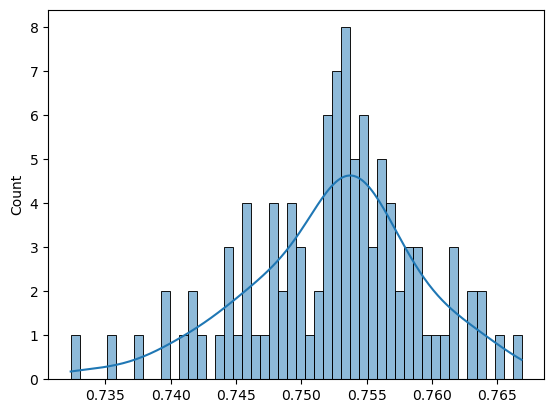

In [19]:
sns.histplot(similarities_test_list_1, bins=50, kde=True)

In [20]:
similarities_test_list_2 = get_similarities(my_dataset_2, test_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Lenovo\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

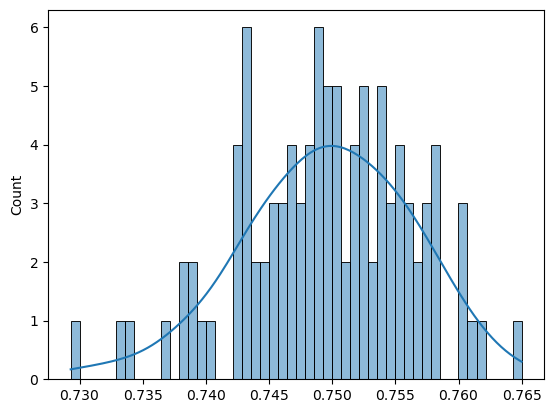

In [21]:
sns.histplot(similarities_test_list_2, bins=50, kde=True)

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

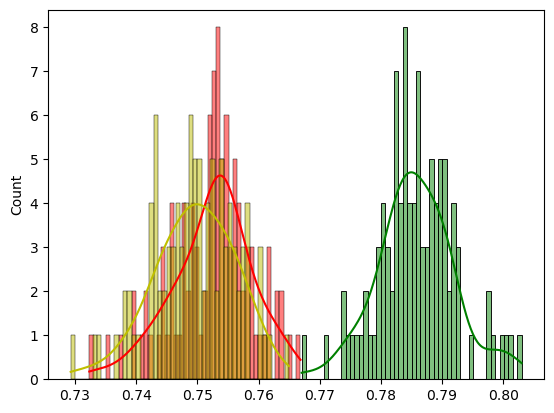

In [22]:
sns.histplot(similarities_list, bins=50, kde=True, color='g')
sns.histplot(similarities_test_list_1, bins=50, kde=True, color='r')
sns.histplot(similarities_test_list_2, bins=50, kde=True, color='y')

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a

(0.665, 0.78)

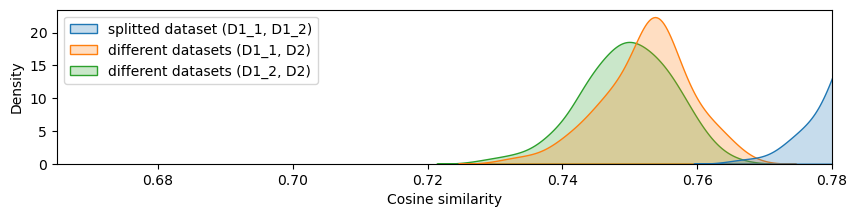

In [23]:
to_plot = pd.DataFrame({
    'splitted dataset (D1_1, D1_2)': similarities_list,
    'different datasets (D1_1, D2)': similarities_test_list_1,
    'different datasets (D1_2, D2)': similarities_test_list_2,
})

# sns.kdeplot(similarities_list,        color='g', fill=True, alpha=0.1)
# sns.kdeplot(similarities_test_list_1, color='r', fill=True, alpha=0.1)
# sns.kdeplot(similarities_test_list_2, color='y', fill=True, alpha=0.1)

plt.figure(figsize=(10,2))
plot = sns.kdeplot(data=to_plot, fill=True)
plot.set_xlabel('Cosine similarity')
plot.set_xlim(0.665, 0.78)


C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a

(0.725, 0.84)

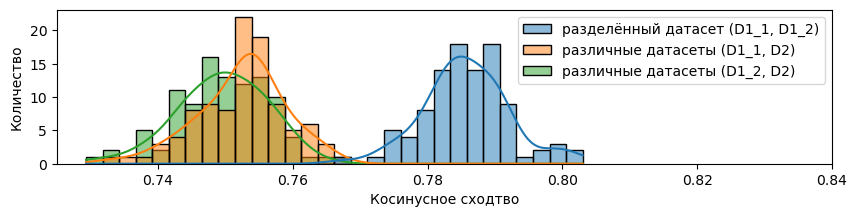

In [24]:
to_plot = pd.DataFrame({
    'разделённый датасет (D1_1, D1_2)': similarities_list,
    'различные датасеты (D1_1, D2)': similarities_test_list_1,
    'различные датасеты (D1_2, D2)': similarities_test_list_2,
})

plt.figure(figsize=(10,2))
plot = sns.histplot(data=to_plot, fill=True, kde=True, bins=30)
plot.set_xlabel('Косинусное сходтво')
plot.set_ylabel('Количество')
plot.set_xlim(0.725, 0.84)


In [47]:
def plot_images(dataset, cnt, random_state=73):
    np.random.seed(random_state)

    idxs = np.random.choice(range(len(dataset)), cnt, replace=False)

    rows = int(np.ceil(cnt ** 0.5))
    cols = int(cnt ** 0.5)
    
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

    for i, idx in enumerate(idxs):
        axs[i // cols, i % cols].imshow(dataset.get_original_image(idx))

    plt.show()

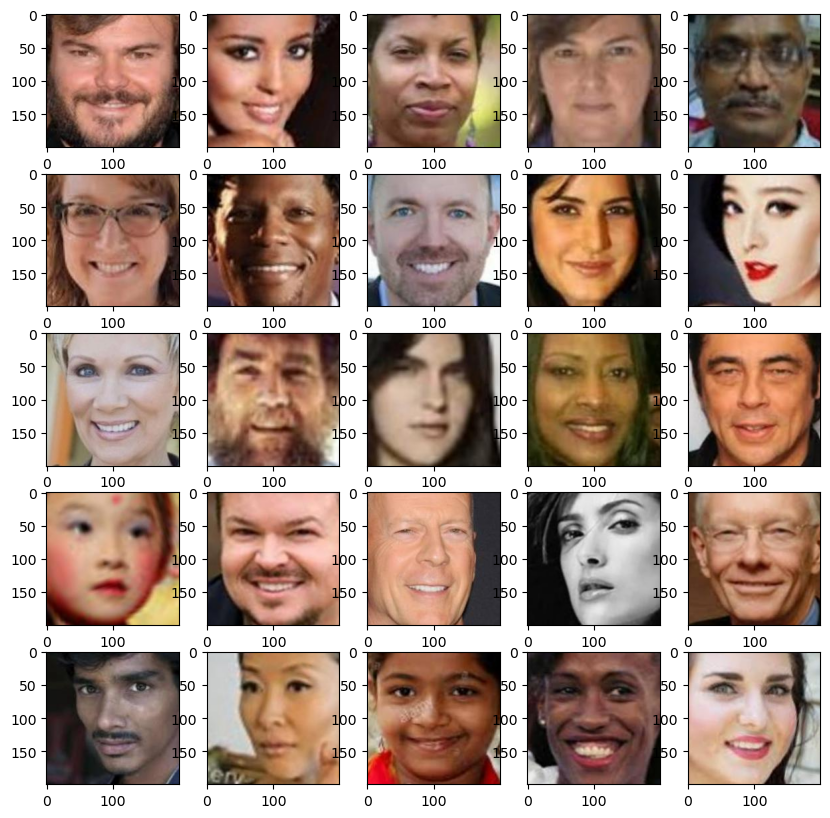

In [48]:
plot_images(my_dataset, 25)

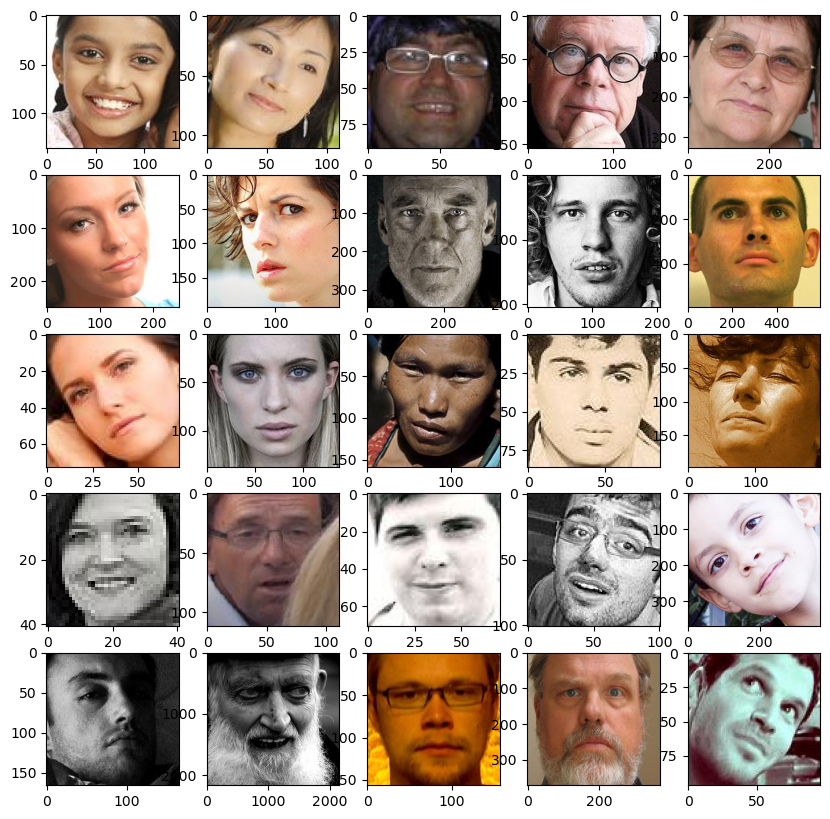

In [49]:
plot_images(test_dataset, 25)

In [59]:
def images_mse(img1: torch.Tensor, img2: torch.Tensor):
    return ((img1.cpu().numpy() - img2.cpu().numpy()) ** 2).mean()

In [62]:
def images_mse(img1: torch.Tensor, img2: torch.Tensor):
    return ((img1 - img2) ** 2).mean()

In [66]:
import torch.utils
import torch.utils.data


def get_images_example(dataset, subsample_size=1_000, random_seed=42):
    np.random.seed(random_seed)
    subsample_size = min(subsample_size, len(dataset))
    idxs = np.random.choice(range(len(dataset)), subsample_size, replace=False)
    subset = torch.utils.data.Subset(dataset, idxs)
    return subset

In [67]:
def images_list_mse(images1, images2):
    mse_sum = 0
    for img1 in images1:
        for img2 in images2:
            mse_sum += images_mse(img1, img2)
    return mse_sum / len(images1) / len(images2)

In [70]:
def get_similarities_mse(ds1, ds2, subsample_size=100, iters=100):
    similarities_list = []
    for seed in tqdm(range(iters)):
        images1, images2 = get_images_example(
            ds1, random_seed=seed, subsample_size=subsample_size), get_images_example(
                ds2, random_seed=seed**2, subsample_size=subsample_size)
        images1, images2 = [img.cpu().numpy() for img in images1], [img.cpu().numpy() for img in images2]
        
        similarities_list.append(images_list_mse(images1, images2))
    return similarities_list

In [71]:
similarities_mse_list = get_similarities_mse(my_dataset_1, my_dataset_2)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Lenovo\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

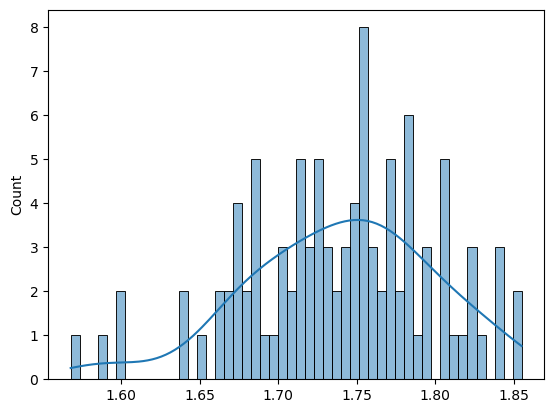

In [72]:
sns.histplot(similarities_mse_list, bins=50, kde=True)

In [74]:
similarities_mse_test_list_1 = get_similarities_mse(my_dataset_1, test_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

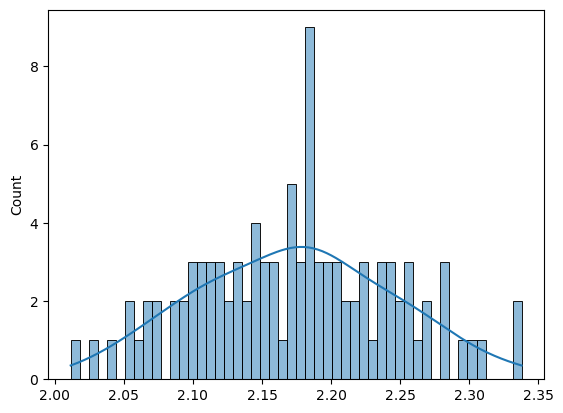

In [75]:
sns.histplot(similarities_mse_test_list_1, bins=50, kde=True)

In [76]:
similarities_mse_test_list_2 = get_similarities_mse(my_dataset_2, test_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Lenovo\anaconda3\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

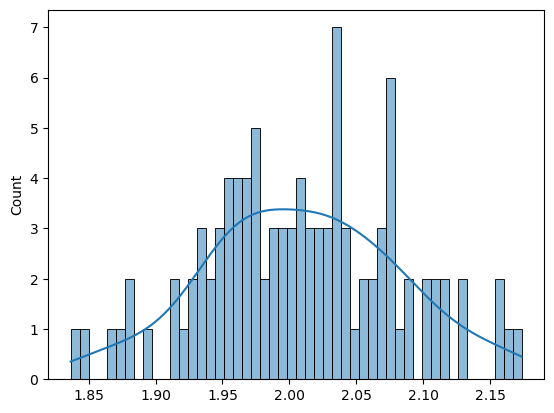

In [77]:
sns.histplot(similarities_mse_test_list_2, bins=50, kde=True)

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a

(1.5, 2.8)

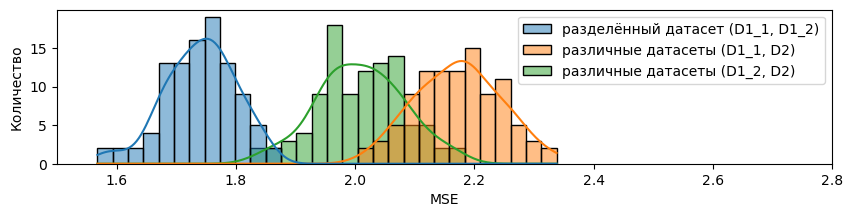

In [82]:
to_plot = pd.DataFrame({
    'разделённый датасет (D1_1, D1_2)': similarities_mse_list,
    'различные датасеты (D1_1, D2)': similarities_mse_test_list_1,
    'различные датасеты (D1_2, D2)': similarities_mse_test_list_2,
})

plt.figure(figsize=(10,2))
plot = sns.histplot(data=to_plot, fill=True, kde=True, bins=30)
plot.set_xlabel('MSE')
plot.set_ylabel('Количество')
plot.set_xlim(1.5, 2.8)
